## Preparing the Environment

In [1]:
from __future__ import print_function
import numpy as np
from scipy.optimize import curve_fit
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from ifqi import envs
from ifqi.evaluation import evaluation
from ifqi.algorithms.fqi.FQI import FQI

%matplotlib inline

In [2]:
env = envs.LQG1D()
state_dim, action_dim, reward_dim = envs.get_space_info(env)
reward_idx = state_dim + action_dim

dataset = evaluation.collect_episodes(env, n_episodes=100)
sast = np.append(dataset[:, :reward_idx],
                 dataset[:, reward_idx + reward_dim:-1],
                 axis=1)
r = dataset[:, reward_idx]



In [3]:
states = discrete_states  = np.linspace(-10, 10, 20)
actions = discrete_actions = np.linspace(-8, 8, 20)

initial_states = np.array([[1, 2, 5, 7, 10]]).T

def make_grid(x, y):
    m = np.meshgrid(x, y, copy=False, indexing='ij')
    return np.vstack(m).reshape(2, -1).T
    

SA = make_grid(states, actions)
S, A = SA[:, 0], SA[:, 1]

## Evaluating the Optimal Q

Optimal K: [[-0.61525125]] Covariance S: 0.001


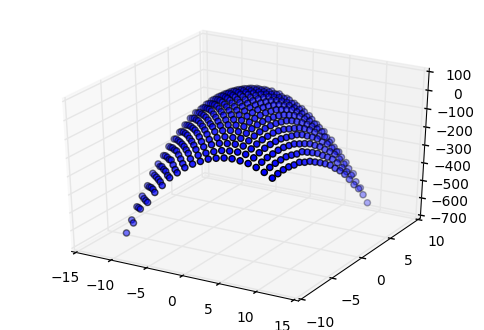

In [4]:
K, cov = env.computeOptimalK(), 0.001
print('Optimal K: {} Covariance S: {}'.format(K, cov))

Q_fun_ = np.vectorize(lambda s, a: env.computeQFunction(s, a, K, cov, 1))
Q_fun = lambda X: Q_fun_(X[:, 0], X[:, 1])

Q_opt = Q_fun(SA)


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(S, A, Q_opt)

In [5]:
class QPolicy:
    def __init__(self, Q):
        self.Q = Q
    
    def draw_action(self, states, absorbing=False, evaluation=False):
        v = self.Q(make_grid(states, actions))
        return actions[v.argmax()]

class OptimalPolicy:
    K = env.computeOptimalK()[0][0]
    
    def draw_action(self, states, absorbing, evaluation=False):
        i = np.abs(actions - self.K*states).argmin()
        #print("states: {} action: {}".format(states, discrete_actions[i]))
        return discrete_actions[i]

def evaluateP(policy, i=initial_states):
    values = evaluation.evaluate_policy(env, policy, initial_states=i)
    print("values (mean {:8.2f},  se {:8.2f})\n steps (mean {:8.2f},  se {:8.2f})".format(*values))
    return values

def evaluateQ(Q, i=initial_states):
    return evaluateP(QPolicy(Q), i)

optimalP = QPolicy(Q_fun)
#optimalP = OptimalPolicy()
_ = evaluateP(optimalP)

values (mean   -66.15,  se    47.74)
 steps (mean   100.00,  se     0.00)


# Learning with FQI and `curve_fit` regressor

In [16]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

class Regressor:
    __slots__ = ('b', 'k')
    
    def __init__(self, b=0, k=0):
        self.b = b
        self.k = k
        
    @property
    def theta(self):
        return (self.b, self.k)
    
    def fit(self, X, y):
        #print("fitting: ", end='')
        (self.b, self.k), pcov = curve_fit(self.Q, X, y)
        #print(self.b, self.k)
    
    def Q(self, sa, b, k):
        #return b - (sa[:, 1] - k *  sa[:, 0]) ** 2
        s, a = sa[:, 0], sa[:, 1]
        return - b * b * s * a - 0.5 * k * a * a - 0.4* k * s * s
    
    def predict(self, X=SA):
        return self.Q(X, self.b, self.k)
    
    def evaluate(self, X=SA):
        Q_hat = self.predict(X)
        Q_opt = Q_fun(X)

        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(X[:, 0], X[:, 1], Q_opt)
        ax.scatter(X[:, 0], X[:, 1], Q_hat, c='r', marker='^')
        
        mae = mean_absolute_error(Q_opt, Q_hat)
        mse = mean_squared_error(Q_opt, Q_hat)
        
        print("       ( mse {:8.2f}, mae {:8.2f})".format(mse, mae))
        print(" theta (   b {:8.2f},   k {:8.2f})".format(*self.theta))

        evaluateQ(self.predict)
        return Q_hat
        
    

## Evaluating regressor using Optimal data

       ( mse   101.03, mae     7.96)
 theta (   k     1.70,   b     5.35)
values (mean   -65.96,  se    47.86)
 steps (mean   100.00,  se     0.00)


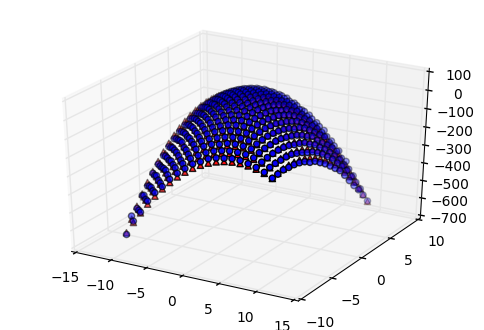

In [8]:
regressor_opt = Regressor()
regressor_opt.fit(SA, Q_opt)

Q_hat = regressor_opt.evaluate()

## Using FQI

In [9]:
regressor = Regressor()
fqi = FQI(estimator=regressor,
          state_dim=state_dim,
          action_dim=action_dim,
          discrete_actions=actions,
          gamma=env.gamma,
          horizon=env.horizon,
          features=None,
          verbose=False)

In [10]:
sa, y = fqi.partial_fit(sast, r)

iterations = 100
for i in range(iterations):
    sa, y = fqi.partial_fit()
    #regressor.evaluate(sa)
    #plt.show()

       ( mse 71326.31, mae   182.36)
 theta (   k     2.87,   b    12.21)
values (mean   -65.49,  se    47.29)
 steps (mean   100.00,  se     0.00)


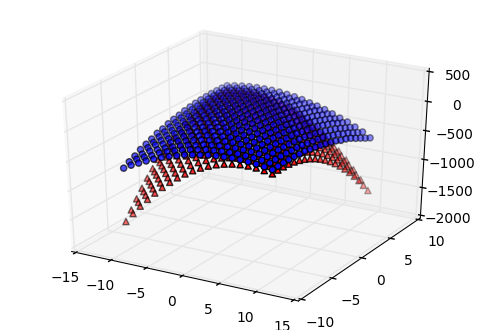

In [12]:
pred = regressor.evaluate()